<div align="right"><i>Бронников Егор</i></p>

# Лабораторная работа №2

## Импорты

In [1]:
from re import compile
from random import choice, choices, randint
from sys import settrace
from collections import defaultdict
from types import FrameType
from typing import Callable, Any, Self
from inspect import getsourcelines, getmodule
from enum import Enum
from string import ascii_letters, digits
from json import dumps, JSONDecodeError
from copy import deepcopy

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from json import loads as json_loads          # https://github.com/python/cpython/tree/3.13/Lib/json
from ujson import loads as ultra_loads        # https://github.com/ultrajson/ultrajson/tree/main/python

from custom_json_parse import parse as custom_parse

## Грамматика JSON

- [Railroad Diagram](https://www.json.org/json-en.html)
- [McKeeman Form](https://www.crockford.com/mckeeman.html)

In [3]:
Grammar = dict[str, list[str]]

In [4]:
JSON_GRAMMAR: Grammar = {
    "<json>": [
        "<element>",
    ],
    "<value>": [
        "<object>",
        "<array>",
        "<string>",
        "<number>",
        "true",
        "false",
        "null",
    ],
    "<object>": [
        "{<ws>}",
        "{<members>}",
    ],
    "<members>": [
        "<member>",
        "<member>,<members>",
    ],
    "<member>": [
         "<ws><string><ws>:<element>"   
    ],
    "<array>": [
        "[<ws>]",
        "[<elements>]",
    ],
    "<elements>": [
        "<element>",
        "<element>,<elements>",
    ],
    "<element>": [
        "<ws><value><ws>",
    ],
    "<string>": [
        '"<characters>"',
    ],
    "<characters>": [
        "",
        "<character><characters>",
    ],
    "<character>": [
        *{chr(index) for index in range(0x0020, 0x10FFFF + 1) if chr(index) != '"' and chr(index) != "\\"},
        "\\<escape>",
    ],
    "<escape>": [
        '"',
        "\\",
        "/",
        "b",
        "f",
        "n",
        "r",
        "t",
        "u<hex><hex><hex><hex>",
    ],
    "<hex>": [
        "<digit>",
        *{chr(index) for index in range(ord("A"), ord("F") + 1)},
        *{chr(index) for index in range(ord("a"), ord("f") + 1)},
    ],
    "<number>": [
        "<integer><fraction><exponent>",
    ],
    "<integer>": [
        "<digit>",
        "<onenine><digits>",
        "-<digit>",
        "-<onenine><digits>",
    ],
    "<digits>": [
        "<digit>",
        "<digit><digits>",
    ],
    "<digit>": [
        '0',
        "<onenine>",
    ],
    "<onenine>": [
        *{chr(index) for index in range(ord("1"), ord("9") + 1)}
    ],
    "<fraction>": [
        "",
        ".<digits>",
    ],
    "<exponent>": [
        "",
        "E<sign><digits>",
        "e<sign><digits>",
    ],
    "<sign>": [
        "",
        "+",
        "-",
    ],
    "<ws>": [
        "",
        "\u0020<ws>",
        "\u000A<ws>",
        "\u000D<ws>",
        "\u0009<ws>",
    ],
}

In [5]:
RE_NONTERMINAL = compile(r"<[^<> ]*>")

In [6]:
def non_terminals(expansion: str | list[str]) -> list[str]:
    if isinstance(expansion, list):
        expansion = expansion[0]

    return RE_NONTERMINAL.findall(expansion)

In [7]:
def is_non_terminal(expansion: str) -> bool:
    return RE_NONTERMINAL.match(expansion) is not None

In [8]:
def simple_grammar_fuzzer(
    grammar: Grammar,
    start: str,
    *,
    max_nonterminals: int,
    max_expansion_trials: int,
) -> str:
    term = start
    expansion_trials = 0

    while len(non_terminals(term)) != 0:
        symbol_to_expand = choice(non_terminals(term))
        expansions = grammar[symbol_to_expand]
        expansion = choice(expansions)

        new_term = term.replace(symbol_to_expand, expansion, 1)

        if len(non_terminals(new_term)) < max_nonterminals:
            term = new_term
            expansions_trials = 0
        else:
            expansion_trials += 1
            if expansion_trials >= max_expansion_trials:
                raise ValueError(f"Cannot expand: {term}")

    return term

In [9]:
valid_json = simple_grammar_fuzzer(
                grammar=JSON_GRAMMAR,
                start="<json>",
                max_nonterminals=10,
                max_expansion_trials=100,
            )

In [10]:
print(repr(valid_json))

'\t\ttrue\r'


In [11]:
print(valid_json)

		true


## Coverage-guided Fuzzer

`Tracer` – класс для отслеживания выполнения программы

In [12]:
class Tracer:
    def __init__(self: Self) -> None:
        self.called_functions = set()
        self.executed_lines = set()

    def reset(self: Self) -> None:
        self.called_functions.clear()
        self.executed_lines.clear()

    def trace_lines(self: Self, frame: FrameType, event: str, arg: Any) -> None:
        if event != "line":
            return
        self.executed_lines.add(frame.f_lineno)

    def trace_calls(self: Self, frame: FrameType, event: str, arg: Any) -> FrameType | None:
        if event != "call":
            return
        func_name = frame.f_code.co_name
        self.called_functions.add(func_name)
        return self.trace_lines
    
    def trace(self: Self, function: Callable[..., Any], *args, **kwargs) -> Any:
        self.reset()
        settrace(self.trace_calls)
        result = function(*args, **kwargs)
        settrace(None)
        return result

__Примеры__

In [13]:
tracer = Tracer()

In [14]:
tracer.trace(json_loads, valid_json)

True

In [15]:
print(tracer.called_functions)

{'loads', 'raw_decode', 'decode'}


In [16]:
print(tracer.executed_lines)

{352, 353, 356, 333, 334, 337, 338, 339, 341, 343, 344, 345, 346}


`CoverageTracker` – класс для отслеживания покрытия

In [17]:
class CoverageTacker:
    def __init__(self: Self, *, function: Callable[..., Any]) -> None:
        self.function = function

        self.covered_lines = set()
        self.tracer = Tracer()

        lines, start_line_number = getsourcelines(getmodule(self.function))
        self.lines = set(range(start_line_number + 1, start_line_number + len(lines) + 2))

    def reset(self: Self) -> None:
        self.covered_lines.clear()

    def run_with_args(self: Self, *args, **kwargs) -> Any:
        self.reset()
        result = self.tracer.trace(self.function, *args, **kwargs)
        self.covered_lines = self.tracer.executed_lines
        return result

__Примеры__

In [18]:
coverage_tracker = CoverageTacker(function=json_loads)

In [19]:
coverage_tracker.run_with_args(valid_json)

True

In [20]:
print(coverage_tracker.covered_lines)

{352, 353, 356, 333, 334, 337, 338, 339, 341, 343, 344, 345, 346}


`RunnerStatus` – результат запуска целевой функции

In [21]:
class RunnerStatus(Enum):
    SUCCESS = "SUCCESS"
    FAILED = "FAILED"

`Runner` – класс для запуска целевой функции

In [22]:
class Runner:
    def __init__(self: Self, *, target: Callable[..., Any]) -> None:
        self.target = target
        self.coverage = CoverageTacker(function=self.target)

    def run_function(self: Self, *args, **kwargs) -> Any:
        return self.target(*args, **kwargs)

    def run_coverage(self: Self, *args, **kwargs) -> Any:
        return self.coverage.run_with_args(*args, **kwargs)

    def run(self: Self, *args, **kwargs) -> tuple[Any, RunnerStatus]:
        status = RunnerStatus.SUCCESS
        result = None
        try:
            result = self.run_coverage(*args, **kwargs)
        except Exception as exception:
            status = RunnerStatus.FAILED

        return result, status

In [23]:
runner = Runner(target=json_loads)

In [24]:
runner.run(valid_json)

(True, <RunnerStatus.SUCCESS: 'SUCCESS'>)

`Mutation` – класс для произведения мутаций

In [25]:
class Mutation:
    def __init__(self: Self, *, individual: str, whitespaces: list[str]) -> None:
        self.individual = individual
        self.whitespaces = whitespaces

    def remove_whitespace(self: Self) -> str:
        mutant = self.individual
        whitespace_indices = [index for index, character in enumerate(self.individual) if character in ' \t\n\r']
        if whitespace_indices:
            index = choice(whitespace_indices)
            mutant = self.individual[:index] + self.individual[index + 1:]
        return mutant

    def replace_whitespace(self: Self) -> str:
        mutant = self.individual
        whitespace_indices = [index for index, character in enumerate(self.individual) if character in ' \t\n\r']
        if whitespace_indices:
            index = choice(whitespace_indices)
            new_whitespace = choice(list(set(self.whitespaces).difference({self.individual[index]})))
            mutant = self.individual[:index] + new_whitespace + self.individual[index + 1:]
        return mutant

    def wrap_with_whitespace(self: Self) -> str:
        return ' ' + self.individual + ' '

__Примеры__

In [26]:
Mutation(whitespaces=[" ", "\t", "\n", "\r"], individual="false\r\t\n\t  \t\r \t ").remove_whitespace()

'false\r\t\n\t  \t\r\t '

In [27]:
Mutation(whitespaces=[" ", "\t", "\n", "\r"], individual="false\r\t\n\t  \t\r \t ").replace_whitespace()

'false\r\t\n\t  \t\r\n\t '

In [28]:
Mutation(whitespaces=[" ", "\t", "\n", "\r"], individual="false\r\t\n\t  \t\r \t ").wrap_with_whitespace()

' false\r\t\n\t  \t\r \t  '

`MutationCoverageFuzzer` – класс для запуска процесса фаззинга на основе покрытия

In [29]:
class MutationCoverageFuzzer:
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        seed: set[str],
        min_mutations: int,
        max_mutations: int,
        tries: int,
    ) -> None:
        self.target = target
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.tries = tries

        self.stats = defaultdict(lambda: 0)
        self.failed_individuals = set()
        self.coverage_stats = []

        self.runner = Runner(target=target)
        self.population = self.seed
        self.coverage_status = {line: False for line in self.runner.coverage.lines}

        self.init()

    def mutate(self: Self, individual: str) -> str:
        mutation = Mutation(individual=individual, whitespaces=[" ", "\t", "\n", "\r"])
        return choice([
            mutation.remove_whitespace,
            mutation.replace_whitespace,
            mutation.wrap_with_whitespace,
        ])()

    def create_candidate(self: Self) -> str:
        candidate = choice(list(self.population))
        mutations_count = randint(self.min_mutations, self.max_mutations)
        for _ in range(mutations_count):
            candidate = self.mutate(candidate)
        return candidate

    def _run(self: Self, individual: str) -> RunnerStatus:
        _, result = self.runner.run(individual)
        covered_lines = self.runner.coverage.covered_lines
        for line in covered_lines:
            if not self.coverage_status[line]:
                self.coverage_status[line] = True
                self.population.add(individual)

        self.stats[result] += 1
        self.coverage_stats.append(len(list(filter(self.coverage_status.get, self.coverage_status))))
        
        if result is RunnerStatus.FAILED:
            self.failed_individuals.add(individual)
        
        return result

    def init(self: Self) -> None:
        for individual in self.seed:
            self._run(individual)

    def run(self: Self) -> None:
        individual = self.create_candidate()
        self._run(individual)

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            self.run()

__Расчёты__

In [30]:
initial_seeds = {simple_grammar_fuzzer(grammar=JSON_GRAMMAR, start="<json>", max_nonterminals=7, max_expansion_trials=100) for _ in range(10)}
initial_seeds

{'\t\t-2.00\t\t\n \r\n\r',
 '\t\r\r [{ \t\r\t\r\r""\t\t\n \t \t:\n\t\n\r\t \r\r\n[{\t}\n\t,  \t\r\rfalse]\n\t\r ,\t\r\t \n \r""\r :\r\t\n\t\t\n \n\n\n\r\n\t\t\r\r\n\t\t  \n\r\r\r\n\n\t \r \n \n\rfalse}]',
 '\t-6.0e+0\r \n\t ',
 '\n\n\n\r\n\r-0.08080730 \r\r\n\n\n \n \t',
 '\n \t\r\n\t\t \r\tfalse\t\n \n \t  \r\t\r\r \r',
 '\r\r\ntrue',
 '\r[\n\n \t\r]',
 ' \tfalse\t',
 '[\r\t\r\r\r\r\n ]\n ',
 'true\r\r '}

In [31]:
mutation_coverage_fuzzer = MutationCoverageFuzzer(
                                target=json_loads,
                                seed=initial_seeds,
                                min_mutations=10,
                                max_mutations=20,
                                tries=500_000,
                            )

In [32]:
mutation_coverage_fuzzer.fuzz()

  0%|          | 0/500000 [00:00<?, ?it/s]

__Результаты__

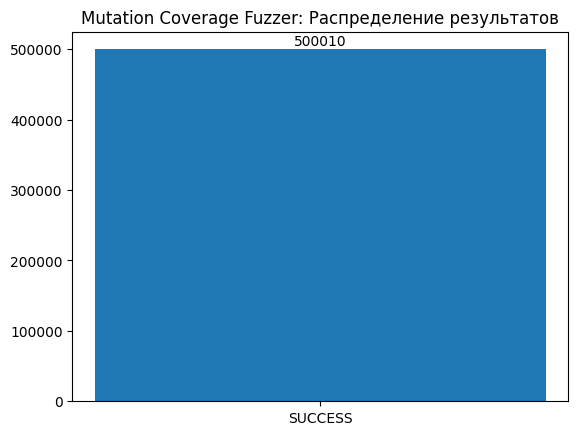

In [33]:
x = list(map(lambda status: status.value, mutation_coverage_fuzzer.stats.keys()))
y = list(mutation_coverage_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Mutation Coverage Fuzzer: Распределение результатов")

for index in range(len(x)):
    plt.text(index, y[index] + 5000, y[index], ha="center")

plt.bar(x, y)
plt.show()

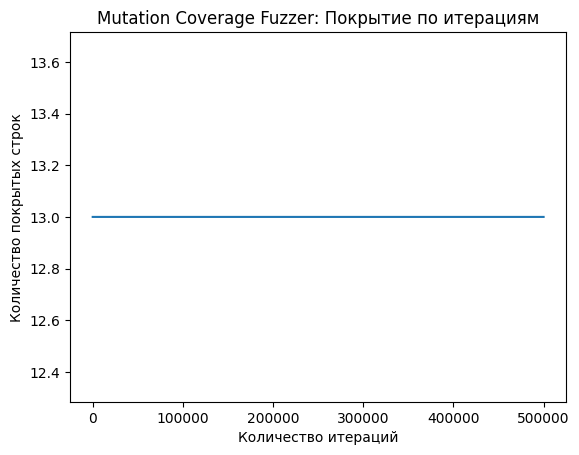

In [34]:
plt.title("Mutation Coverage Fuzzer: Покрытие по итерациям")
plt.plot(mutation_coverage_fuzzer.coverage_stats)
plt.xlabel("Количество итераций")
plt.ylabel("Количество покрытых строк")
plt.show()

## Cheating Mutations

In [35]:
class CheatingMutation:
    def __init__(self: Self, *, individual: str, whitespaces: list[str]) -> None:
        self.individual = individual
        self.whitespaces = whitespaces

    @staticmethod
    def is_valid_json(json_string: str) -> bool:
        try:
            json_loads(json_string)
            return "Infinity" not in json_string 
        except JSONDecodeError:
            return False

    def add_random_character(self: Self) -> str:
        random_char = choice(ascii_letters)
        position = randint(0, len(self.individual) - 1)
        return self.individual[:position] + random_char + self.individual[position:]
    
    def remove_random_character(self: Self) -> str:
        if len(self.individual) <= 1:
            return self.individual

        position = randint(0, len(self.individual) - 1)
        return self.individual[:position] + self.individual[position + 1:]
    
    def replace_random_value(self: Self) -> str:
        try:
            json_object = json_loads(self.individual)
            if isinstance(json_object, dict):
                key_to_replace = choice(list(json_object.keys()))
                json_object[key_to_replace] = "".join(choices(ascii_letters, k=5))
            elif isinstance(json_object, list):
                index_to_replace = randint(0, len(json_object) - 1)
                json_object[index_to_replace] = "".join(choices(ascii_letters, k=5))
            return dumps(json_object)
        except Exception:
            return self.individual

In [40]:
class CheatingMutationCoverageFuzzer:
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        seed: set[str],
        min_mutations: int,
        max_mutations: int,
        tries: int,
    ) -> None:
        self.target = target
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.tries = tries

        self.stats = defaultdict(lambda: 0)
        self.failed_individuals = set()
        self.coverage_stats = []

        self.runner = Runner(target=target)
        self.population = seed
        self.coverage_status = {line: False for line in self.runner.coverage.lines}

        self.init()

    def mutate(self: Self, individual: str) -> str:
        mutation = CheatingMutation(individual=individual, whitespaces=[" ", "\t", "\n", "\r"])
        return choice([
            mutation.add_random_character,
            mutation.remove_random_character,
            mutation.replace_random_value,
        ])()

    def create_candidate(self: Self) -> str:
        candidate = choice(list(self.population))
        mutations_count = randint(self.min_mutations, self.max_mutations)
        for _ in range(mutations_count):
            mutant = self.mutate(candidate)
            if CheatingMutation.is_valid_json(mutant):
                candidate = mutant
        return candidate

    def _run(self: Self, individual: str) -> RunnerStatus:
        _, result = self.runner.run(individual)
        covered_lines = deepcopy(self.runner.coverage.covered_lines)
        for line in covered_lines:
            if line in self.coverage_status and not self.coverage_status[line]:
                self.coverage_status[line] = True
                self.population.add(individual)

        self.stats[result] += 1
        self.coverage_stats.append(len(list(filter(self.coverage_status.get, self.coverage_status))))
        
        if result is RunnerStatus.FAILED:
            self.failed_individuals.add(individual)
        
        return result

    def init(self: Self) -> None:
        for individual in self.seed:
            self._run(individual)

    def run(self: Self) -> None:
        individual = self.create_candidate()
        self._run(individual)

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            self.run()

__Расчёты__

In [41]:
initial_seeds = {simple_grammar_fuzzer(grammar=JSON_GRAMMAR, start="<json>", max_nonterminals=10, max_expansion_trials=100) for _ in range(10)}
initial_seeds

{'\t\r \r \n\r"\U0004cfe4\U0008e15c\U000b8501\U0010b8a8\U000ba335𤉾"',
 '\t     \t[]\r\n',
 '\tnull\n',
 '\t{\n"\U00100c4f":\r\r-0\r,\r"\U000c9522"\n\r\t \t:\n\r\t\t\t\rfalse\n }\n \r\n\r\n',
 '\n"" ',
 '\r \r\t-50',
 ' \n \r\r\n\r\n""',
 ' ""\n\r',
 '""  \r\r\r\r\t \t\n      \t\r',
 '{ \r\n}\r'}

In [42]:
mutation_coverage_fuzzer = CheatingMutationCoverageFuzzer(
                                target=custom_parse,
                                seed=initial_seeds,
                                min_mutations=20,
                                max_mutations=30,
                                tries=500_000,
                            )

In [43]:
mutation_coverage_fuzzer.fuzz()

  0%|          | 0/500000 [00:00<?, ?it/s]

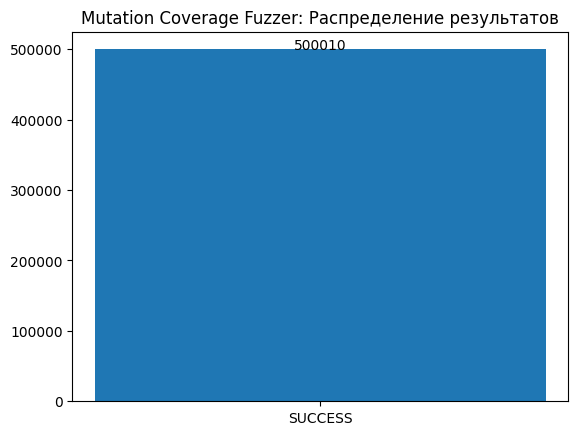

In [44]:
x = list(map(lambda status: status.value, mutation_coverage_fuzzer.stats.keys()))
y = list(mutation_coverage_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Mutation Coverage Fuzzer: Распределение результатов")

for index in range(len(x)):
    plt.text(index, y[index] + 1, y[index], ha="center")

plt.bar(x, y)
plt.show()

In [45]:
mutation_coverage_fuzzer.failed_individuals

set()

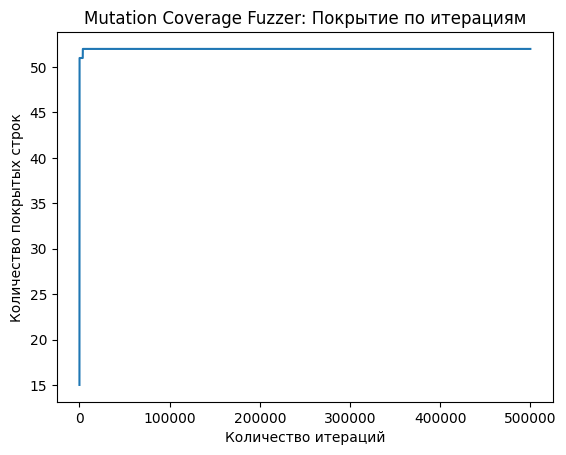

In [46]:
plt.title("Mutation Coverage Fuzzer: Покрытие по итерациям")
plt.plot(mutation_coverage_fuzzer.coverage_stats)
plt.xlabel("Количество итераций")
plt.ylabel("Количество покрытых строк")
plt.show()

In [47]:
len(mutation_coverage_fuzzer.population)

11

In [48]:
mutation_coverage_fuzzer.population

{'\t\r \r \n\r"\U0004cfe4\U0008e15c\U000b8501\U0010b8a8\U000ba335𤉾"',
 '\t     \t[]\r\n',
 '\tnull\n',
 '\t{\n"\U00100c4f":\r\r-0\r,\r"\U000c9522"\n\r\t \t:\n\r\t\t\t\rfalse\n }\n \r\n\r\n',
 '\n"" ',
 '\r \r\t-50',
 ' \n \r\r\n\r\n""',
 ' ""\n\r',
 '""  \r\r\r\r\t \t\n      \t\r',
 '5.0',
 '{ \r\n}\r'}